In [2]:
import numpy as np
from scipy.signal import fftconvolve, hilbert
from obspy import read, Stream, Trace
import matplotlib.pyplot as plt
from matplotlib import gridspec
from obspy.core import AttribDict

# def function
def smooth_avg(arr, winlen):
    """
    Smoothing a time series by averaging its values in a moving window. This averaging 
    window operation can be done efficiently with an convolution in the frequency domain.
    """

    window = np.ones(winlen) / (1.0 * winlen)
    return fftconvolve(arr, window, 'same')

def spectral_whitening(arr, delta, freq_width, returnweight=False):
    """
    Frequency whitening of a time series by balancing its spectrum by smoothed absolute
    array of the spectrum.
    
    arr        : input seismogram
    delta      : sampling time step of the input
    freq_width : spectral whitening width
    returnweith: return the averaging width or not
    """
    npts = len(arr)
    carr = np.fft.fftshift(np.fft.fft(arr, 2*npts-1))

    Nyfreq = 0.5 / delta
    spec_step = Nyfreq / npts
    if freq_width != None:
        winlen = int(0.5 * freq_width / spec_step) * 2 + 1
        weight = smooth_avg(np.abs(carr), winlen)
        if any(weight < 1e-8): raise Exception('Zero division')
        
        carr /= weight
        carr[weight<1e-8] = 0

    if returnweight:
        return carr[npts-1:2*npts], weight[npts-1:2*npts]
    else:
        return carr[npts-1:2*npts]
    
def compute_whiten_auto(tr,freq_width,lc,hc):
    delta=tr.stats.delta
    npts=tr.stats.npts
    whiten_spectrum=spectral_whitening(tr.data,tr.stats.delta,freq_width)
    w_auto = np.fft.irfft(np.abs(whiten_spectrum)**2)
    w_auto_tr=Trace(header={'npts':len(w_auto),'delta':delta},data=w_auto)
    # post processing: tapering and filtering
    taper_width = 10/(w_auto_tr.stats.npts * w_auto_tr.stats.delta)
    w_auto_tr.taper(type='cosine', max_percentage=taper_width)
    w_auto_tr.filter('bandpass', freqmin=lc, freqmax=hc, corners=4, zerophase=True)
    w_auto_tr.taper(type='cosine', max_percentage=taper_width)
    return w_auto_tr

def data_stack(stream, order):
    stack = 0
    phase = 0j
    
    if order == 0:
        for acorr in stream:
            stack += acorr.data
        stack /= len(stream)
        return Trace(header={'npts': len(stack), 'delta': stream[0].stats.delta}, data=stack)
    else:
        for acorr in stream:
            stack += acorr.data

            ## calculate phase
            asig = hilbert(acorr.data)
            phase += asig / np.abs(asig)
        stack /= len(stream)
        weight = np.abs(phase / len(stream))
        return Trace(header={'npts': len(stack), 'delta': stream[0].stats.delta}, data=stack * weight**order)


## **Question 1**

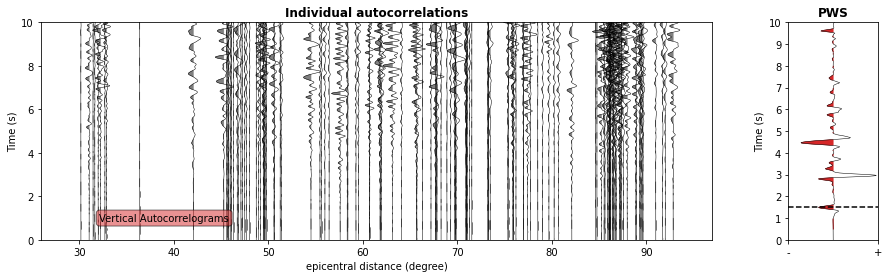

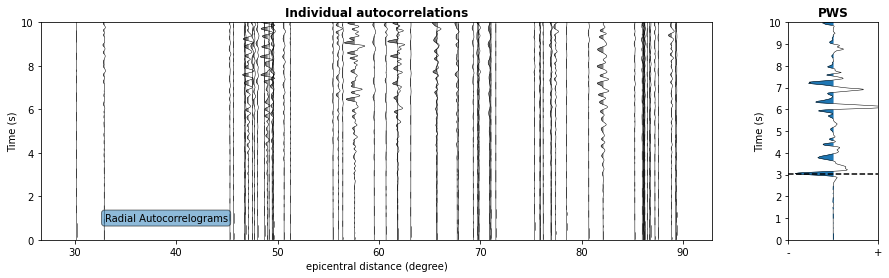

In [3]:
freq_width = 0.75
lc = 1.0
hc = 5.0
props1 = dict(boxstyle='round', facecolor='tab:red', alpha=0.5)
props2 = dict(boxstyle='round', facecolor='tab:blue', alpha=0.5)

# read data
stz = read("ST01/*Z.SAC")
stn = read("ST01/*N.SAC")
# eqlocation = np.genfromtxt("ST01/selected_earthquakes.txt")

# for the vertical
st = stz.copy()
auto_stream = Stream()




for i in range(len(st)):
    dt = st.traces[i].stats.starttime
    st.traces[i].trim(dt+15, dt + 55) # trim data (10 seconds before and 30 second after)    
    whiten_auto=compute_whiten_auto(st.traces[i],freq_width,lc,hc) # NOTE: change data here
    whiten_auto.normalize()
    # epi_dist=random.randint(30,95)
    sacd=AttribDict()
    sacd.gcarc=st.traces[i].stats.sac.gcarc
    whiten_auto.stats.sac = sacd
    auto_stream = auto_stream + whiten_auto
time=np.arange(whiten_auto.stats.npts)*whiten_auto.stats.delta
# plot
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 2,hspace=0.3,width_ratios=[7.5, 1])
ax0=plt.subplot(gs[0,0])
for auto in auto_stream:
    time=np.arange(auto.stats.npts)*auto.stats.delta
    auto.data /= np.max(np.abs(auto.data))
    epi_dist = auto.stats.sac.gcarc
    ax0.plot(auto.data + epi_dist, time, lw=0.5, color='black')
    ax0.fill_betweenx(time, epi_dist, auto.data + epi_dist, lw=0.5,color='gray', where=(auto.data < 0))
ax0.set_ylim(0,10)
ax0.text(39,1,"Vertical Autocorrelograms",
         horizontalalignment='center', verticalalignment='center', bbox=props1);
ax0.set_xlabel("epicentral distance (degree)")
ax0.set_ylabel("Time (s)")
ax0.set_title("Individual autocorrelations",weight='bold')
ax1=plt.subplot(gs[0,1])
stack=data_stack(auto_stream,2)
time=np.arange(stack.stats.npts)*stack.stats.delta
stack.normalize()
ax1.plot(stack.data, time, lw=0.5, color='black')
ax1.fill_betweenx(time, 0, stack.data, lw=0.5, color='tab:red', where=(stack.data < 0))
ax1.set_ylim(0,10)
ax1.set_xlim(-0.15,0.15)
plt.xticks([-0.15,0.15],['-', '+'])
plt.yticks(np.arange(0,11))
ax1.hlines(y=1.5, xmin=-0.15, xmax=0.15, color='black', linestyle='dashed')
ax1.set_ylabel("Time (s)")
ax1.set_title("PWS",weight='bold')
plt.show()


# for the radial
st = stn.copy()
auto_stream = Stream()
for i in range(len(st)):
    dt = st.traces[i].stats.starttime
    st.traces[i].trim(dt+15, dt + 55) # trim data (10 seconds before and 30 second after)    
    whiten_auto=compute_whiten_auto(st.traces[i],freq_width,lc,hc) # NOTE: change data here
    whiten_auto.normalize()
    # epi_dist=random.randint(30,95)
    sacd=AttribDict()
    sacd.gcarc=st.traces[i].stats.sac.gcarc
    whiten_auto.stats.sac = sacd
    auto_stream = auto_stream + whiten_auto
time=np.arange(whiten_auto.stats.npts)*whiten_auto.stats.delta
# plot
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(1, 2,hspace=0.3,width_ratios=[7.5, 1])
ax0=plt.subplot(gs[0,0])
for auto in auto_stream:
    time=np.arange(auto.stats.npts)*auto.stats.delta
    auto.data /= np.max(np.abs(auto.data))
    epi_dist = auto.stats.sac.gcarc
    ax0.plot(auto.data + epi_dist, time, lw=0.5, color='black')
    ax0.fill_betweenx(time, epi_dist, auto.data + epi_dist, lw=0.5,color='gray', where=(auto.data < 0))
ax0.set_ylim(0,10)
ax0.text(39,1,"Radial Autocorrelograms",
        horizontalalignment='center', verticalalignment='center', bbox=props2);
ax0.set_xlabel("epicentral distance (degree)")
ax0.set_ylabel("Time (s)")
ax0.set_title("Individual autocorrelations",weight='bold')
ax1=plt.subplot(gs[0,1])
stack=data_stack(auto_stream,2)
time=np.arange(stack.stats.npts)*stack.stats.delta
stack.normalize()
ax1.plot(stack.data, time, lw=0.5, color='black')
ax1.fill_betweenx(time, 0, stack.data, lw=0.5, color='tab:blue', where=(stack.data < 0))
ax1.set_ylim(0,10)
ax1.set_xlim(-0.015,0.015)
plt.xticks([-0.015,0.015],['-', '+'])
plt.yticks(np.arange(0,11))
ax1.set_ylabel("Time (s)")
ax1.set_title("PWS",weight='bold')
ax1.hlines(y=3.02, xmin=-0.015, xmax=0.015, color='black', linestyle='dashed')
plt.show()

The $V_p/V_s$ velocity ratio is:
$$
{V_p\over V_s} = {t_{2s}\over t_{2p}} = {3.0\over 1.5} = 2.0 
$$

The first peak at 1.5 second present the time delay for $2p$ then the peak at 3 second presents the time depay for $2p^2$. Similarly, we have the first peak at 3 second present the time delay for $2s$ then the peak at 6 second presents the time depay for $2s^2$...

## **Question 2**

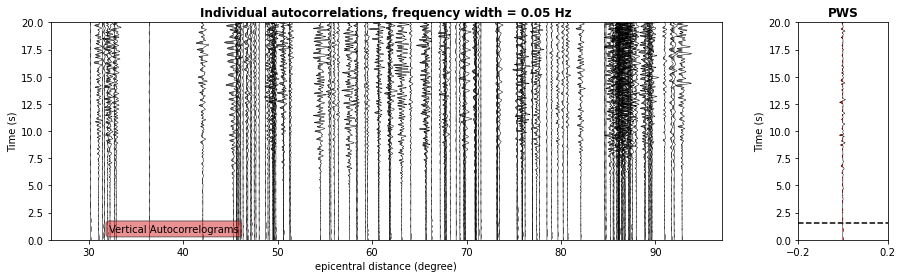

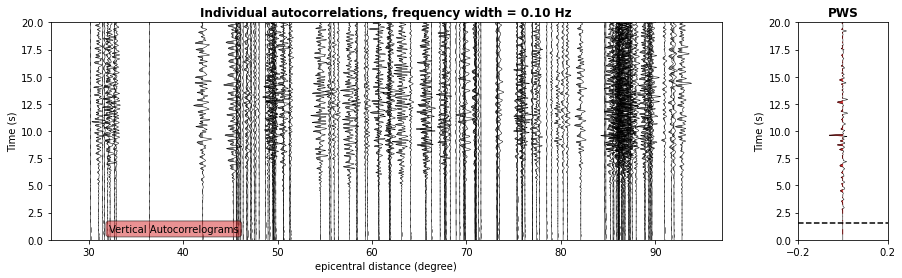

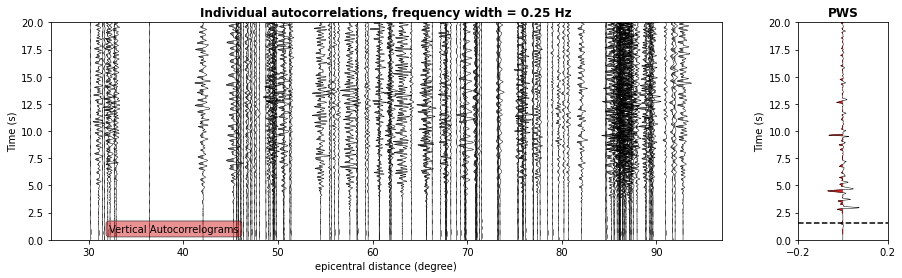

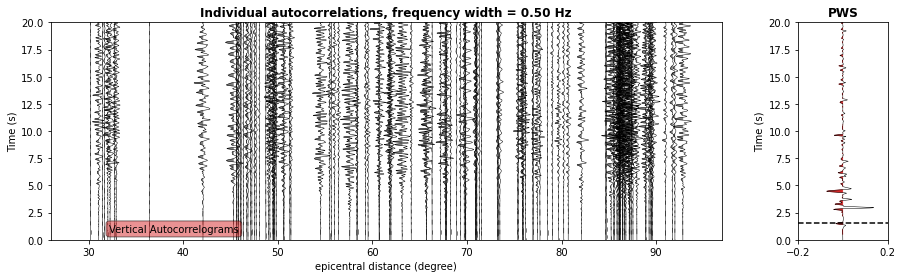

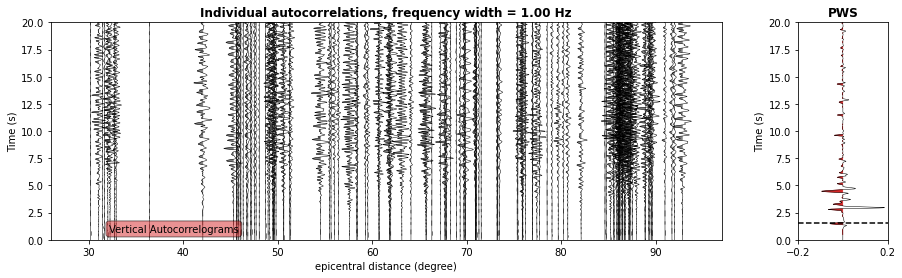

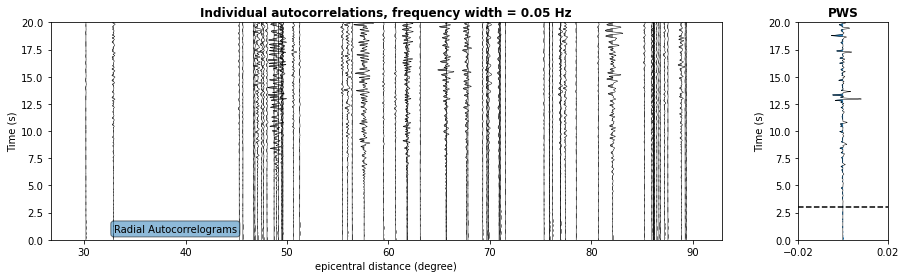

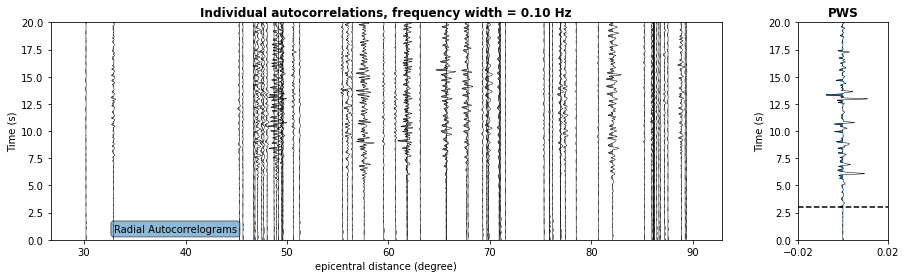

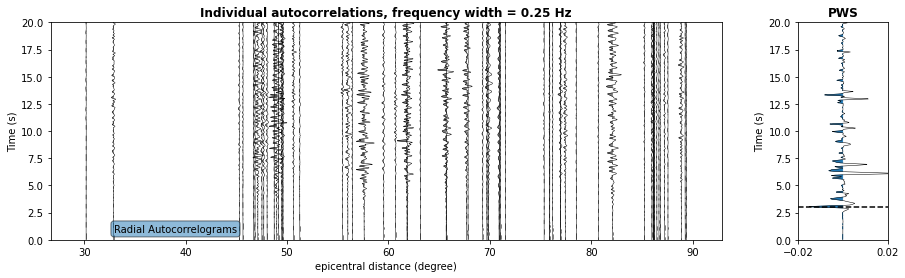

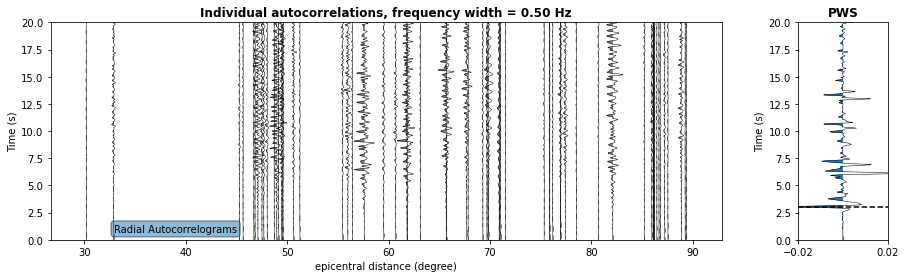

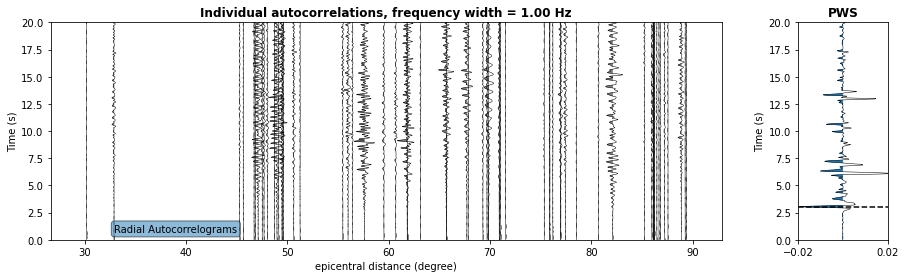

In [34]:
frequency_width = [0.05, 0.10, 0.25, 0.50, 1.00]

lc = 1.0
hc = 5.0

# for the vertical
for freq_width in frequency_width:
    auto_stream = Stream()
    st = stz.copy()
    for i in range(len(st)):
        dt = st.traces[i].stats.starttime
        st.traces[i].trim(dt+15, dt + 55) # trim data (10 seconds before and 30 second after)    
        whiten_auto=compute_whiten_auto(st.traces[i],freq_width,lc,hc) # NOTE: change data here
        whiten_auto.normalize()
        # epi_dist=random.randint(30,95)
        sacd=AttribDict()
        sacd.gcarc=st.traces[i].stats.sac.gcarc
        whiten_auto.stats.sac = sacd
        auto_stream = auto_stream + whiten_auto
    time=np.arange(whiten_auto.stats.npts)*whiten_auto.stats.delta
    # plot
    fig = plt.figure(figsize=(15, 4))
    gs = gridspec.GridSpec(1, 2,hspace=0.3,width_ratios=[7.5, 1])
    ax0=plt.subplot(gs[0,0])
    for auto in auto_stream:
        time=np.arange(auto.stats.npts)*auto.stats.delta
        auto.data /= np.max(np.abs(auto.data))
        epi_dist = auto.stats.sac.gcarc
        ax0.plot(auto.data + epi_dist, time, lw=0.5, color='black')
        ax0.fill_betweenx(time, epi_dist, auto.data + epi_dist, lw=0.5,color='gray', where=(auto.data < 0))
    ax0.set_ylim(0,20)
    ax0.text(39,1,"Vertical Autocorrelograms",
              horizontalalignment='center', verticalalignment='center', bbox=props1);

    ax0.set_xlabel("epicentral distance (degree)")
    ax0.set_ylabel("Time (s)")
    ax0.set_title("Individual autocorrelations, frequency width = %.2f Hz" %freq_width,weight='bold')
    ax1=plt.subplot(gs[0,1])
    stack=data_stack(auto_stream,2)
    time=np.arange(stack.stats.npts)*stack.stats.delta
    stack.normalize()
    ax1.plot(stack.data, time, lw=0.5, color='black')
    ax1.fill_betweenx(time, 0, stack.data, lw=0.5, color='tab:red', where=(stack.data < 0))
    ax1.set_ylim(0,20)
    ax1.set_xlim(-0.2,0.2)
    plt.xticks([-0.2,0.2])
    # plt.yticks(np.arange(0,11))
    ax1.hlines(y=1.5, xmin=-0.2, xmax=0.2, color='black', linestyle='dashed')
    ax1.set_ylabel("Time (s)")
    ax1.set_title("PWS",weight='bold')
    plt.show()


# for the radial
for freq_width in frequency_width:
    auto_stream = Stream()
    st = stn.copy()
    for i in range(len(st)):
        dt = st.traces[i].stats.starttime
        st.traces[i].trim(dt+15, dt + 55) # trim data (10 seconds before and 30 second after)    
        whiten_auto=compute_whiten_auto(st.traces[i],freq_width,lc,hc) # NOTE: change data here
        whiten_auto.normalize()
        # epi_dist=random.randint(30,95)
        sacd=AttribDict()
        sacd.gcarc=st.traces[i].stats.sac.gcarc
        whiten_auto.stats.sac = sacd
        auto_stream = auto_stream + whiten_auto
    time=np.arange(whiten_auto.stats.npts)*whiten_auto.stats.delta
    # plot
    fig = plt.figure(figsize=(15, 4))
    gs = gridspec.GridSpec(1, 2,hspace=0.3,width_ratios=[7.5, 1])
    ax0=plt.subplot(gs[0,0])
    for auto in auto_stream:
        time=np.arange(auto.stats.npts)*auto.stats.delta
        auto.data /= np.max(np.abs(auto.data))
        epi_dist = auto.stats.sac.gcarc
        ax0.plot(auto.data + epi_dist, time, lw=0.5, color='black')
        ax0.fill_betweenx(time, epi_dist, auto.data + epi_dist, lw=0.5,color='gray', where=(auto.data < 0))
    ax0.set_ylim(0,20)
    ax0.text(39,1,"Radial Autocorrelograms",
            horizontalalignment='center', verticalalignment='center', bbox=props2);
    ax0.set_xlabel("epicentral distance (degree)")
    ax0.set_ylabel("Time (s)")
    ax0.set_title("Individual autocorrelations, frequency width = %.2f Hz" %freq_width,
                  weight='bold')
    ax1=plt.subplot(gs[0,1])
    stack=data_stack(auto_stream,2)
    time=np.arange(stack.stats.npts)*stack.stats.delta
    stack.normalize()
    ax1.plot(stack.data, time, lw=0.5, color='black')

    ax1.fill_betweenx(time, 0, stack.data, lw=0.5, color='tab:blue', where=(stack.data < 0))
    ax1.set_ylim(0,20)
    ax1.set_xlim(-0.02,0.02)
    plt.xticks([-0.02,0.02])
    # plt.yticks(np.arange(0,11))
    ax1.set_ylabel("Time (s)")
    ax1.set_title("PWS",weight='bold')
    ax1.hlines(y=3.02, xmin=-0.02, xmax=0.02, color='black', linestyle='dashed')
    plt.show()

## **Question 3**

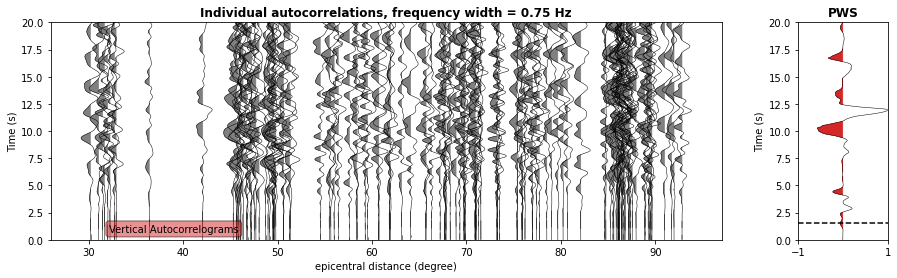

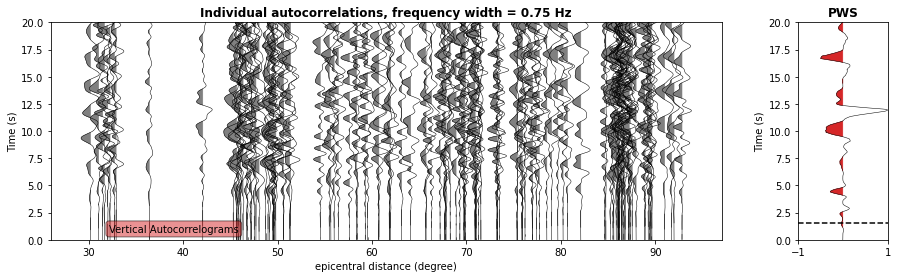

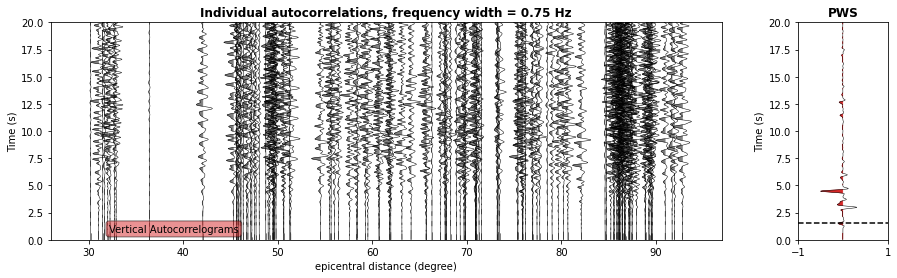

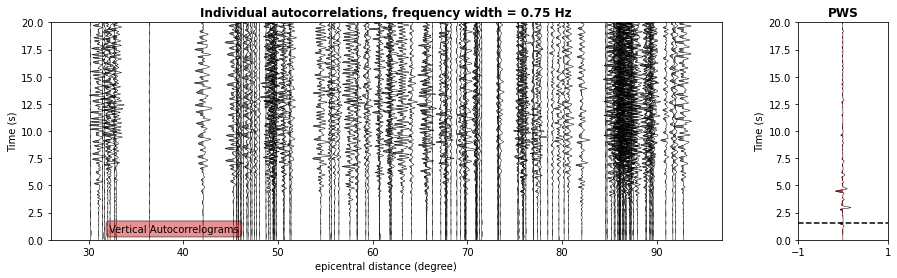

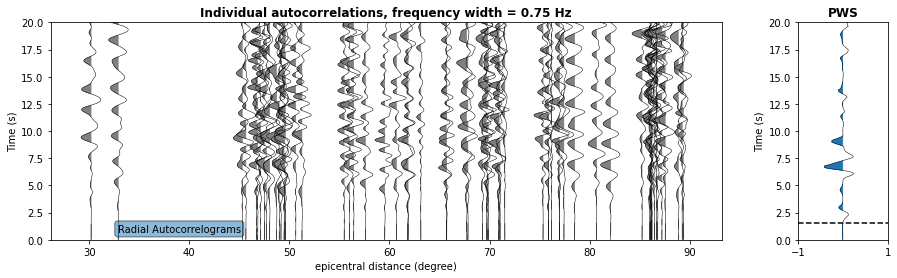

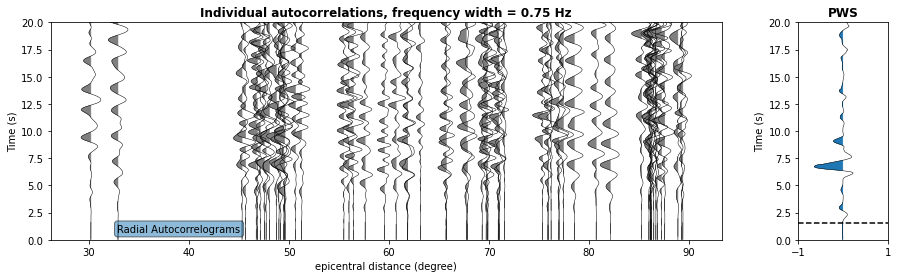

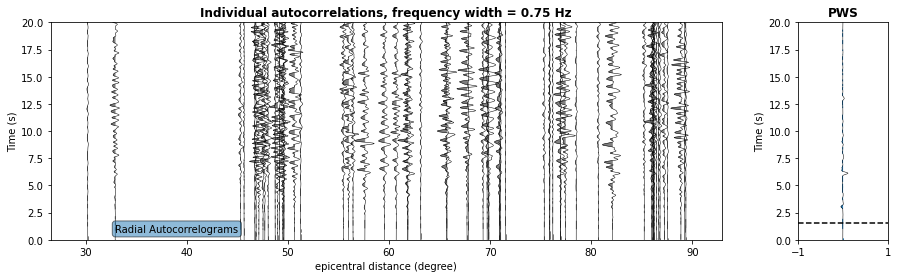

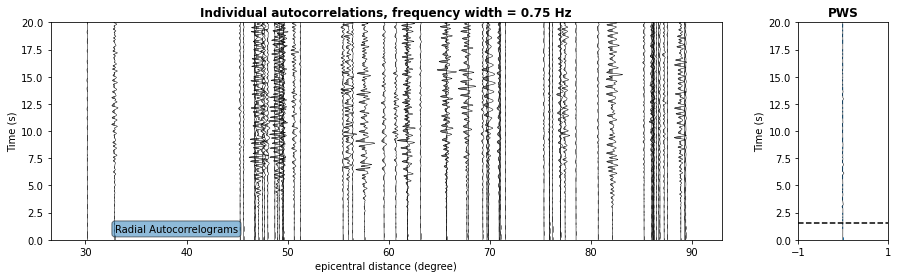

In [5]:
freq_width = 0.75

low_corner_freq = [0.20, 0.25, 0.50, 1.00]
hig_corner_freq = [1.0 , 1.0 , 3.0 , 4.00]

# for the vertical
for j in range(len(low_corner_freq)):
    lc = low_corner_freq[j]
    hc = hig_corner_freq[j]
    auto_stream = Stream()
    st = stz.copy()
    for i in range(len(st)):
        dt = st.traces[i].stats.starttime
        st.traces[i].trim(dt+15, dt + 55) # trim data (10 seconds before and 30 second after)    
        whiten_auto=compute_whiten_auto(st.traces[i],freq_width,lc,hc) # NOTE: change data here
        whiten_auto.normalize()
        # epi_dist=random.randint(30,95)
        sacd=AttribDict()
        sacd.gcarc=st.traces[i].stats.sac.gcarc
        whiten_auto.stats.sac = sacd
        auto_stream = auto_stream + whiten_auto
    time=np.arange(whiten_auto.stats.npts)*whiten_auto.stats.delta
    # plot
    fig = plt.figure(figsize=(15, 4))
    gs = gridspec.GridSpec(1, 2,hspace=0.3,width_ratios=[7.5, 1])
    ax0=plt.subplot(gs[0,0])
    for auto in auto_stream:
        time=np.arange(auto.stats.npts)*auto.stats.delta
        auto.data /= np.max(np.abs(auto.data))
        epi_dist = auto.stats.sac.gcarc
        ax0.plot(auto.data + epi_dist, time, lw=0.5, color='black')
        ax0.fill_betweenx(time, epi_dist, auto.data + epi_dist, lw=0.5,color='gray', where=(auto.data < 0))
    ax0.set_ylim(0,20)
    ax0.text(39,1,"Vertical Autocorrelograms",
              horizontalalignment='center', verticalalignment='center', bbox=props1);

    ax0.set_xlabel("epicentral distance (degree)")
    ax0.set_ylabel("Time (s)")
    ax0.set_title("Individual autocorrelations, frequency width = %.2f Hz" %freq_width,weight='bold')
    ax1=plt.subplot(gs[0,1])
    stack=data_stack(auto_stream,2)
    time=np.arange(stack.stats.npts)*stack.stats.delta
    stack.normalize()
    ax1.plot(stack.data, time, lw=0.5, color='black')
    ax1.fill_betweenx(time, 0, stack.data, lw=0.5, color='tab:red', where=(stack.data < 0))
    ax1.set_ylim(0,20)
    ax1.set_xlim(-1.,1.)
    plt.xticks([-1.,1.])
    # plt.yticks(np.arange(0,11))
    ax1.hlines(y=1.5, xmin=-1., xmax=1., color='black', linestyle='dashed')
    ax1.set_ylabel("Time (s)")
    ax1.set_title("PWS",weight='bold')
    plt.show()


# for the radial
for j in range(len(low_corner_freq)):
    lc = low_corner_freq[j]
    hc = hig_corner_freq[j]
    auto_stream = Stream()
    st = stn.copy()
    for i in range(len(st)):
        dt = st.traces[i].stats.starttime
        st.traces[i].trim(dt+15, dt + 55) # trim data (10 seconds before and 30 second after)    
        whiten_auto=compute_whiten_auto(st.traces[i],freq_width,lc,hc) # NOTE: change data here
        whiten_auto.normalize()
        # epi_dist=random.randint(30,95)
        sacd=AttribDict()
        sacd.gcarc=st.traces[i].stats.sac.gcarc
        whiten_auto.stats.sac = sacd
        auto_stream = auto_stream + whiten_auto
    time=np.arange(whiten_auto.stats.npts)*whiten_auto.stats.delta
    # plot
    fig = plt.figure(figsize=(15, 4))
    gs = gridspec.GridSpec(1, 2,hspace=0.3,width_ratios=[7.5, 1])
    ax0=plt.subplot(gs[0,0])
    for auto in auto_stream:
        time=np.arange(auto.stats.npts)*auto.stats.delta
        auto.data /= np.max(np.abs(auto.data))
        epi_dist = auto.stats.sac.gcarc
        ax0.plot(auto.data + epi_dist, time, lw=0.5, color='black')
        ax0.fill_betweenx(time, epi_dist, auto.data + epi_dist, lw=0.5,color='gray', where=(auto.data < 0))
    ax0.set_ylim(0,20)
    ax0.text(39,1,"Radial Autocorrelograms",
            horizontalalignment='center', verticalalignment='center', bbox=props2);
    ax0.set_xlabel("epicentral distance (degree)")
    ax0.set_ylabel("Time (s)")
    ax0.set_title("Individual autocorrelations, frequency width = %.2f Hz" %freq_width,weight='bold')
    ax1=plt.subplot(gs[0,1])
    stack=data_stack(auto_stream,2)
    time=np.arange(stack.stats.npts)*stack.stats.delta
    stack.normalize()
    ax1.plot(stack.data, time, lw=0.5, color='black')
    ax1.fill_betweenx(time, 0, stack.data, lw=0.5, color='tab:blue', where=(stack.data < 0))
    ax1.set_ylim(0,20)
    ax1.set_xlim(-1.,1.)
    plt.xticks([-1.,1.])
    # plt.yticks(np.arange(0,11))
    ax1.hlines(y=1.5, xmin=-1., xmax=1., color='black', linestyle='dashed')
    ax1.set_ylabel("Time (s)")
    ax1.set_title("PWS",weight='bold')
    plt.show()

## **Question 4**

## **Question 5**

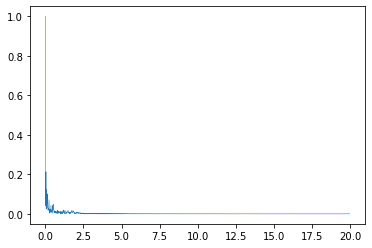

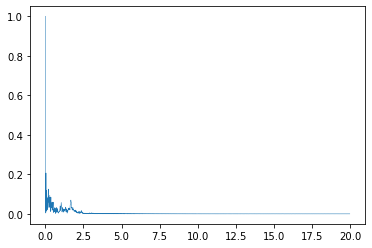

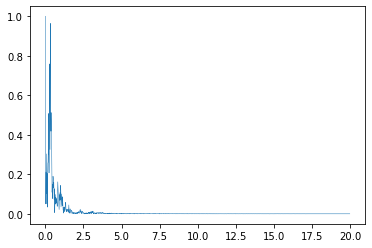

In [32]:
stz_sep13 = read("ST01/2010-09-13T7.15.50_ST01_BHN.SAC")
stn_sep13 = read("ST01/2010-09-13T7.15.50_ST01_BHZ.SAC")
stz_feb15 = read("ST01/2010-02-15T21.51.50_ST01_BHZ.SAC")

def fftplot(tr):
    dt = tr.stats.starttime
    tr.trim(dt+15, dt + 55) # trim data (10 seconds before and 30 second after)
    npts = tr.stats.npts
    NF=0.5/tr.stats.delta
    npts=tr.stats.npts
    fft_tr=np.fft.fftshift(np.fft.fft(tr.data, 2*npts-1))[npts-1:2*npts]
    new_delta=NF/len(fft_tr)
    freq=np.arange(len(fft_tr))*new_delta
    plt.figure()
    plt.plot(freq,np.abs(fft_tr)/max(np.abs(fft_tr)),linewidth=0.5)

fftplot(stz_sep13.traces[0])
fftplot(stn_sep13.traces[0])
fftplot(stz_feb15.traces[0])